# **Tutorial 9: Paleoclimate Data Assimilation**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Brodie Pearson

**Content editors:** Agustina Pesce

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

###**Code and Data Sources**

The code for this notebook is based on [code available from Erb et al. (2022)](https://github.com/Holocene-Reconstruction/Holocene-code) and workflow presented during the [Paleoclimate Data Assimilation Workshop 2022](https://github.com/michaelerb/da-workshop).

Data from the following sources are used in this tutorial:

*   Matthew B. Osman, Jessica E. Tierney, Jiang Zhu, Robert Tardif, Gregory J. Hakim, Jonathan King, Christopher J. Poulsen. 2021. Globally resolved surface temperatures since the Last Glacial Maximum. Nature, 599, 239-244. doi: 10.1038/s41586-021-03984-4
*   King, J. M., Tierney, J., Osman, M., Judd, E. J., & Anchukaitis, K. J. (2023). DASH: A MATLAB Toolbox for Paleoclimate Data Assimilation. Geoscientific Model Development, (in review).



















#**Tutorial 9 Objectives**

As we just discussed in the introductory video, proxies and models both have advantages and limitations for reconstructing past changes in earth's climate system. One approach for combining the strengths of both paleoclimate proxies and models is data assimilation. In this tutorial, we'll look at paleoclimate reconstructions that were made with data assimilation. The specific reconstruction we'll be analyzing is the Last Glacial Maximum reanalysis (LGMR) from [Osman et al. (2021)](https://www.nature.com/articles/s41586-021-03984-4), which contains temperature and d18O data for the past 24,000 years.


By the end of this tutorial you will be able to:

*   Understand how data assimilation works
*   Exisiting paleoclimate data assimilation datasets
*   Why data assimilation is useful
*   How to create time series and maps of data assimilation results 






In [ ]:
# Install libraries
!pip install --no-binary shapely shapely --force # Add this to use cartopy. in this way it doesn't crush
!pip install cartopy
!pip install pooch 
!pip install xarray

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 67.1 MB/s eta 0:00:00
  Created wheel for shapely: filename=shapely-2.0.1-cp39-cp39-linux_x86_64.whl size=979525 sha256=b91b3abebed0e023172f1d2dd5d16b03c6f1179f

In [ ]:
# Import libraries
import pooch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.util as cutil

##Load the LGMR paleoclimate data assimilation reconstruction

This dataset contains reconstructions of surface air temperature (SAT), d18O, and global mean surface temperature (GMST). Let's download the paleoclimate reconstruction for SAT. 

In [ ]:
data_path= pooch.retrieve(
  url="https://www.ncei.noaa.gov/pub/data/paleo/reconstructions/osman2021/LGMR_SAT_climo.nc",
  known_hash=None,
)

dataset = xr.open_dataset(data_path)

SHA256 hash of downloaded file: 31b9dd39206b3979479521cd4f62cc1579f0d86118d3bbc7fc5068219f2d480f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.9/dist-packages/xarray/coding/variables.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


To see what's in the file you loaded, we can print the xarray:

In [ ]:
# Variables in the file
dataset

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

In [ ]:
print('\n=== Notes about extracted variables ===')
print('Shape of "tas_mean":', dataset['sat'].shape)
print('Range of "ages":', dataset['age'].min().values, dataset['age'].max().values)
print('Range of "lat":', dataset['lat'].min().values, dataset['lat'].max().values)
print('Range of "lon":', dataset['lon'].min().values, dataset['lon'].max().values)


=== Notes about extracted variables ===
Shape of "tas_mean": (120, 96, 144)
Range of "ages": 100.0 23900.0
Range of "lat": -90.0 90.0
Range of "lon": 0.0 357.5


## Plotting a **time series** of the paleoclimate data assimilation

Now that the data is loaded, we can plot a time series of the temperature data to beginning to assess global changes.

However, the `tas_mean` variable is a 3D array with dimensions of age-lat-lon, so we first need to calculate a global mean. The function below calculates the mean temperature value over a specified region. In this case, we'll be looking at the global mean.

In [ ]:
def spatial_mean(dataset, variable, region):
  """A function to compute a regional-mean from a time-lat-lon variable"""
  i_selected = np.where((dataset.lon >= region[0]) & (dataset.lon <= region[1]))[0]
  j_selected = np.where((dataset.lat >= region[2]) & (dataset.lat <= region[3]))[0]
  print(
    'Computing spatial mean.',
    f'lats: {dataset.lat.values[j_selected[0]]} - {dataset.lat.values[j_selected[-1]]}', 
    f'lons: {dataset.lon.values[i_selected[0]]} - {dataset.lon.values[i_selected[-1]]}.',
    'Points are inclusive.'
  )
  lat_weights = np.cos(np.radians(dataset.lat))
  variable_zonal = np.nanmean(dataset[variable].values[:, :, i_selected], axis=2)
  variable_mean = np.average(
      variable_zonal[:, j_selected], 
      axis=1, 
      weights=lat_weights[j_selected]
  )
  
  return variable_mean

In [ ]:
print('Temperature:', dataset['sat'][:,40,40].values)

Temperature: [25.00663  25.012339 24.97276  25.006624 25.025883 25.022503 25.021257
 24.93759  24.953253 24.92007  24.911415 24.90081  24.889858 24.877974
 24.866053 24.86699  24.844736 24.83374  24.829748 24.814796 24.796558
 24.77175  24.78531  24.796917 24.728544 24.70938  24.697655 24.655146
 24.632723 24.622665 24.650679 24.63602  24.624628 24.628693 24.55594
 24.50801  24.517727 24.560318 24.58738  24.550005 24.406488 24.368305
 24.354279 24.327545 24.318422 24.307615 24.317335 24.243074 24.27002
 24.240465 24.258146 24.187737 24.17693  24.15457  24.106544 24.008389
 23.890287 23.77974  23.600834 23.47094  23.35355  23.269182 23.228994
 23.244436 23.272703 23.304958 23.285358 23.195267 23.204578 23.1766
 23.126982 23.065403 22.968515 22.930487 22.826202 22.758928 22.625048
 22.55789  22.453196 22.451893 22.344    22.254086 22.192375 22.071222
 22.039116 21.979877 21.896212 21.798069 21.647514 21.57923  21.579681
 21.587729 21.569918 21.482063 21.358282 21.365383 21.348495 21.3182

/usr/local/lib/python3.9/dist-packages/xarray/coding/variables.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Call the function above, `spatial_mean`, to compute a global mean surface temperature.

In [ ]:
# Calculate the global mean surface temperature
region = [0,360,-90,90]
tas_global_mean = spatial_mean(dataset, 'sat', region)

Computing spatial mean. lats: -90.0 - 90.0 lons: 0.0 - 357.5. Points are inclusive.


Now that we calculated our global mean, we can plot the results as a time series to assess changes in temperature over the past 24,000 years:

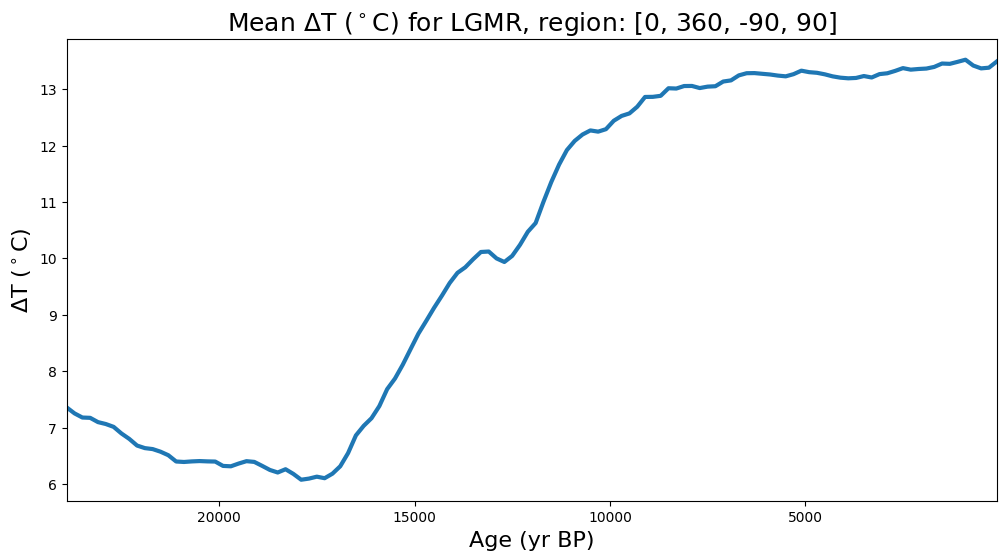

In [ ]:
# Plot the global mean surface temperature
f,ax1 = plt.subplots(1, 1, figsize=(12,6))
ax1.plot(dataset['age'], tas_global_mean, linewidth=3)

ax1.set_xlim(dataset['age'].max().values, dataset['age'].min().values)
ax1.set_ylabel('$\Delta$T ($^\circ$C)', fontsize=16)
ax1.set_xlabel('Age (yr BP)', fontsize=16)
ax1.set_title(
  f'Mean $\Delta$T ($^\circ$C) for LGMR, region: {region}', 
  fontsize=18, 
  loc='center'
)
plt.show()

Consider the following questions:


*   How has global temperature varied over the past 24,000 years?
*   What climate forcings may have contributed to the increase in temperature ~17,000 years ago? 



## Plotting a **temperature anomaly map** of the paleoclimate data assimilation

Data assimilation creates spatial reconstructions, so we can also make figures showing spatial temperature anomalies for different time periods. The function below makes two figures: one that shows a map of reconstructed temperature, and the other that shows a zonal mean figure of temperature differences.

In [ ]:
# A function to make a map of differences between two time periods
def map_temp_anom(dataset, variable_name, ages_anom,ages_ref):
    # Compute the difference between the periods specified above.
    ind_anom = np.where((dataset.age >= ages_anom[0]) & (dataset.age <= ages_anom[1]))[0]
    ind_ref  = np.where((dataset.age >= ages_ref[0])  & (dataset.age <= ages_ref[1]))[0]

    tas_change = np.mean(dataset[variable_name][ind_anom, :, :], axis=0) - np.mean(dataset[variable_name][ind_ref, :, :], axis=0)
    tas_change_zonal = np.mean(tas_change, axis=1)

    # Make a map of changes
    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    tas_change.plot(
        ax=ax,
        transform=ccrs.PlateCarree(), x="lon", y="lat", 
        cbar_kwargs={'orientation': 'horizontal', 'label':'$\Delta$T ($^\circ$C)'}
    )
    ax.coastlines()
    ax.set_title(
        f'$\Delta$T ($^\circ$C) for LGMR, ages: anom = {ages_anom}, ref = {ages_ref}',
        loc='center',
        fontsize=16
    )
    ax.gridlines(color='k',linewidth=1,linestyle=(0,(1,5)))
    ax.spines['geo'].set_edgecolor('black')
    plt.show()
    
    # Make a zonal mean figure of the changes
    fig, ax1 = plt.subplots(1, 1)
    tas_change_zonal.plot(linewidth=3, y="lat")
    ax1.axvline(x=0,color='gray',alpha=1,linestyle=':',linewidth=2)
    ax1.set_ylim(-90, 90)
    ax1.set_xlabel('$\Delta$T ($^\circ$C)')
    ax1.set_ylabel('Latitude ($^\circ$)')
    ax1.set_title(
        f'Zonal-mean $\Delta$T ($^\circ$C), ages: anom = {ages_anom}, ref = {ages_ref}',
        loc='center',
    )
    plt.show()

Before making the figures, double-check the ages in your dataset by printing the beginning and end of the age variable.

In [ ]:
print('First 5 ages:', dataset.age[:5].values)
print('Last 5 ages:', dataset.age[-5:].values)

First 5 ages: [100. 300. 500. 700. 900.]
Last 5 ages: [23100. 23300. 23500. 23700. 23900.]


The code below will make a figure that shows the temperature anomaly temperature anomaly of 21,000 years ago relative to today.

/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


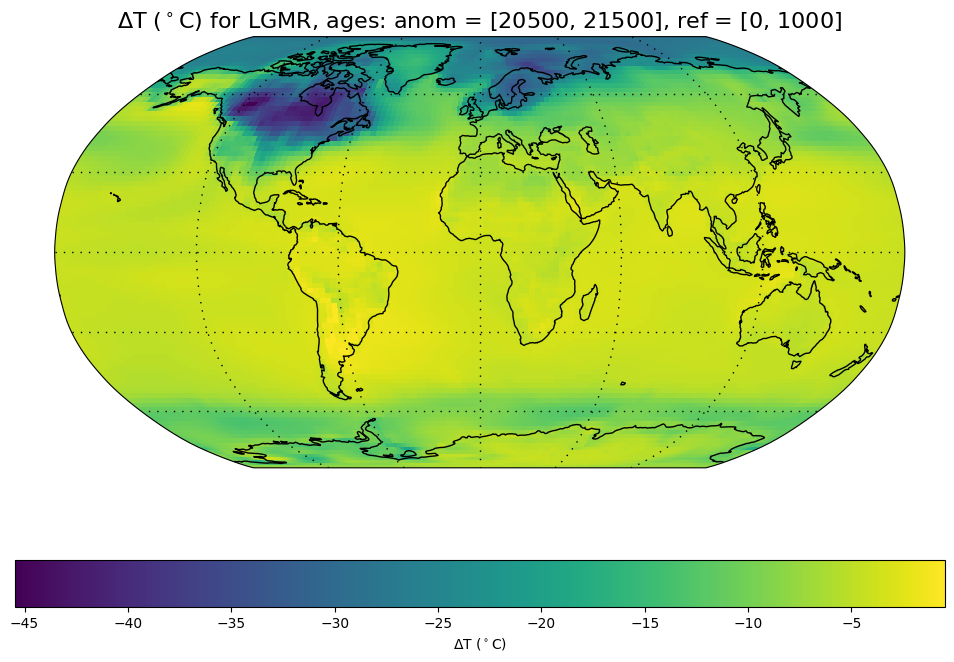

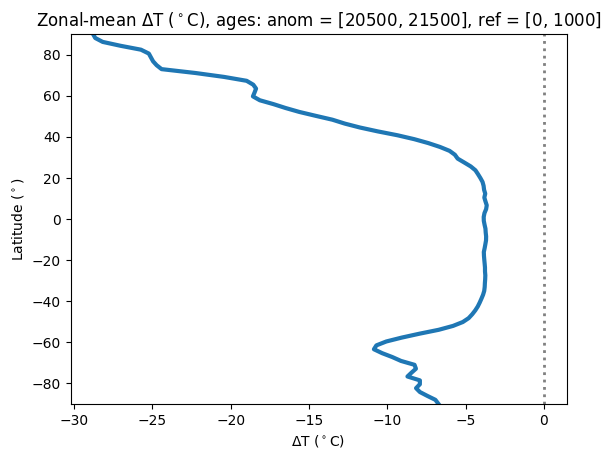

In [ ]:
# Make a map of differences between ages
ages_anom = [20500,21500]; ages_ref = [0,1000]  # 21 ka vs 0 ka

map_temp_anom(dataset, 'sat', ages_anom, ages_ref)

What do you notice about the spatial differences in the LGM to present temperature anomalies?


*   How does the temperature anomaly vary with latitude?
*   Where was the largest temperature change? Why might this region region have undergone the largest temperature change during this time?

If you'd like, you can take a look at temperature anomalies during other time periods as well by changing the `ages_anom` and `ages_ref` values.